In [1]:
from itertools import product

import numpy as np
import pandas as pd
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import harmonic_mean
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm9_metrics import *

In [2]:
top10 = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

negs = [
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "effective_edge_positivity"
]

key_features = [
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
]

In [ ]:
from tqdm.notebook import tqdm

edges = np.load(f"{outputdir}/esm_test9_edges.npy")

n = (lambda arr: (-1 + np.sqrt(1 + 8 * arr.size)) / 2)(edges[0])
ppc = np.fromiter(map(positive_pathway_coverage, edges), float).reshape(-1, 1)
maxped = np.fromiter(map(lambda arr: 1 - max_positive_edge_density(arr), edges), float).reshape(-1, 1)
maxsed = np.fromiter(map(lambda arr: 1 - max_synergetic_edge_density(arr), edges), float).reshape(-1, 1)
meanped = np.fromiter(map(lambda arr: 1 - mean_positive_edge_density(arr), edges), float).reshape(-1, 1)
pc = np.fromiter(map(pathway_coverage, edges), float).reshape(-1, 1)
eep = np.fromiter(map(lambda arr: 1 - effective_edge_positivity(arr), edges), float).reshape(-1, 1)

full = np.hstack([ppc, maxped, maxsed, meanped, pc, eep])

arr_top10 = np.hstack([
    np.fromiter(
        map(
            (lambda arr: 1 - eval(f)(arr)) if f in negs else eval(f), 
            edges
        ), float
    ).reshape(-1, 1) for f in top10
])


df = pd.concat(
    [
        pd.read_feather(f"{outputdir}/esm_test4.feather"),
        pd.DataFrame(
            arr_top10,
            columns=top10
        ),
        pd.DataFrame({
            f"arithmetic{i + 1}": mat.mean(axis=1) for i, mat in tqdm(enumerate(
                [
                    full[:, np.where(arr_bool)[0]] for arr_bool in map(
                        lambda lst_bool: np.array(lst_bool), 
                        product(*[[True, False]] * 6)
                    ) if arr_bool.sum() > 1
                ]
            ))
        })
    ],
    axis=1
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

In [ ]:
df

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
import seaborn as sns

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score

import warnings
warnings.simplefilter('ignore')

fig, ax = plt.subplots(figsize=(3, 3))

metrics = {
    # "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    # "specificity": specificity_score,
    "F$_1$": f1_score,
    # "AUROC": roc_auc_score,
    # "AP": average_precision_score,
}

argmax_recorder = {}

cmap = sns.color_palette("husl", len(metrics))

for  i, (k, metric) in enumerate(metrics.items()):
    x, y = cai_performance_plot(df, metric)
    ax.plot(x, y, color=cmap[i])
    idx = np.argmax(y)
    argmax_max = (x[idx], y[idx])
    ax.scatter(
        *argmax_max, 
        label=f"{k} ({argmax_max[1].round(3)})",
        color=cmap[i]
    )
    ax.vlines(*argmax_max, -0.05, color=cmap[i], linestyle="--", zorder=-100, alpha=.3)
    ax.text(argmax_max[0], .03, "$\leq$" + f"{argmax_max[0].round(2)}", color=cmap[i], ha="left", va="bottom")
    
    argmax_recorder = {**argmax_recorder, k: argmax_max[0]}

ax.set_xlim(-.05, 1.05)
ax.set_ylim(-.05, 1.05)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")

ax.set_title("Decision thresholds for\nadopting PB designs (ESM9)", size="medium")
ax.set(xlabel="CAI", ylabel="scores")

fig.savefig(f"{outputdir}/decision_thresh_test9", **kwarg_savefig)

In [8]:
def div22():
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.hstack([
        ppc, 
        maxped
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div3():
    weight = np.array([1, n, (n + 1) * (n - 1), 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div1234():
    weight = np.array([1, n, n ** 2, 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div123():
    weight = np.array([1, n, n ** 2])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div234():
    weight = np.array([n, n ** 2, 1])
    val = np.hstack([
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div23():
    weight = np.array([n, n ** 2])
    val = np.hstack([
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()

In [9]:
# df = pd.concat(
#     [
#         df, 
#         pd.DataFrame(dict(
#             div22=div22(),
#             div3=div3(),
#             div1234=div1234(),
#             div123=div123(),
#             div234=div234(),
#             div23=div23()
#         ))
#     ],
#     axis=1
# )

[Text(0, 0.5, 'f1')]

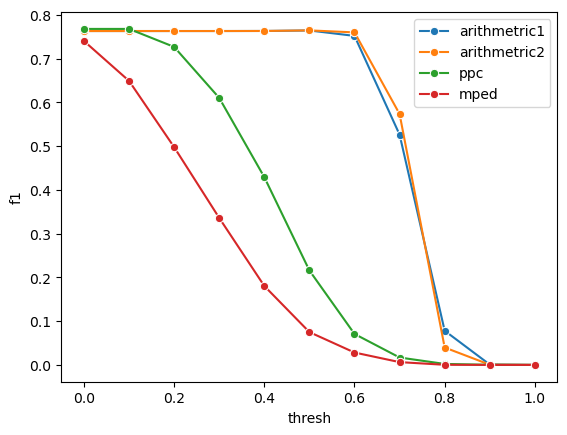

In [33]:
from sklearn.metrics import f1_score

fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 11)
hoge = pd.DataFrame({
    "thresh": thresh,
    # "div22": np.vectorize(lambda t: f1_score(df.better_with_pb, df.div22 > t))(thresh),
    "arithmetric1": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic1 > t))(thresh),
    "arithmetric2": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic2 > t))(thresh),
    "ppc": np.vectorize(lambda t: f1_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: f1_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in [
    # "div22", 
    "arithmetric1", "arithmetric2", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )
    
ax.set(ylabel="f1")

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

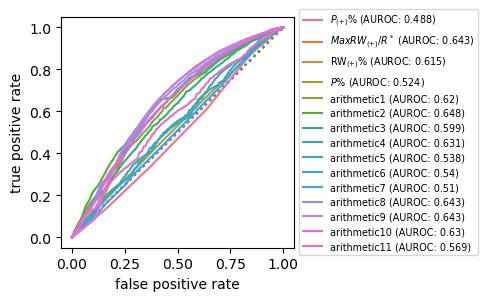

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    df.positive_pathway_coverage, 
    df.max_positive_edge_density_neg, 
    df.mean_positive_edge_density_neg,
    df.pathway_coverage,
] + [
    eval("df.arithmetic" + f"{i + 1}") for i in range(11)
]

names = [
    "$P_{(+)}\%$", "$MaxRW_{(+)}/R^*$", r"RW$_{(+)}$%", "$P\%$",
]+ [
    f"arithmetic{i + 1}" for i in range(11)
]



cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="false positive rate", ylabel="true positive rate")

fig.savefig(f"{outputdir}/test9_roc", **kwarg_savefig)

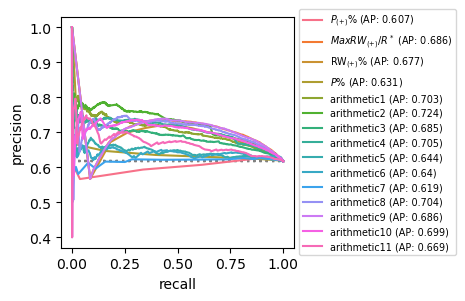

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test9_pr", **kwarg_savefig)

In [73]:
model_phi = np.array([
    1, 1, 0, 0, 0, 1, 1, 0, -1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 0,
    -1, 0, 0, 0, 0,
    0, -1, 0, 0,
    -1, 0, 0,
    0, 0,
    1
])

model_psi = np.array([
    1, -1, 0, 0, 0, 0, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
])

model_lambda = np.array([
    1, -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, -1, 1, 0, 0,
    0, -1, 0, 0,
    1, 0, 0,
    -1, 1,
    0
])

In [88]:
def good_metric(arr):
    return np.mean([
        positive_pathway_coverage(arr),
        1 - max_positive_edge_density(arr),
        1 - mean_positive_edge_density(arr)
    ])

In [89]:
vals = np.sort(df.arithmetic2.unique())
# vals = thresh

thresh_recorder = {
    v:  vals[np.argmax(
        np.vectorize(lambda t: eval(f"{v}_score")(
            df.better_with_pb, df.arithmetic2 > t
        ))(vals)
    )] for v in ["precision", "recall", "f1"]
}

thresh_recorder

{'precision': 0.8759259259259259,
 'recall': 0.34933862433862434,
 'f1': 0.560042735042735}

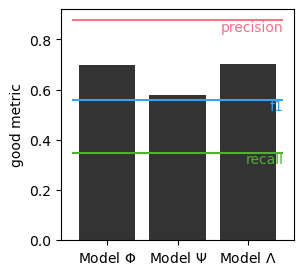

In [90]:
fig, ax= plt.subplots(figsize=(3, 3))

sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$", "Model $\Lambda$"],
        "good metric": map(good_metric, [model_phi, model_psi, model_lambda])
    }),
    x="", y="good metric", ax=ax, color=".2"
)

xlim = ax.get_xlim()

for i, (k, v) in enumerate(thresh_recorder.items()):
    c = sns.color_palette("husl", len(thresh_recorder))
    ax.hlines(v, *xlim, color=c[i], label=k)
    ax.text(xlim[1], v, k, ha="right", va="top", color=c[i])

In [92]:
def n_eff2(arr):
    return np.array([
        (arr[9] != 0) & (
            (arr[1] != 0) or \
            (arr[(17, 2),] != 0).all() or \
            (arr[(17, 24, 3),] != 0).all() or (arr[(17, 24, 30, 4),] != 0).all() or (arr[(17, 24, 30, 35, 5),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(17, 24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(17, 24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(17, 24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(17, 24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(17, 24, 30, 36, 6),] != 0).all() or (arr[(17, 24, 30, 36, 42, 7),] != 0).all() or (arr[(17, 24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(17, 24, 30, 37, 7),] != 0).all() or (arr[(17, 24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 38, 8),] != 0).all() or \
            (arr[(17, 24, 31, 5),] != 0).all() or \
            (arr[(17, 24, 31, 39, 6),] != 0).all() or (arr[(17, 24, 31, 39, 42, 7),] != 0).all() or (arr[(17, 24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 31, 39, 43, 8),] != 0).all() or (arr[(17, 24, 31, 40, 7),] != 0).all() or (arr[(17, 24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(17, 24, 31, 41, 8),] != 0).all() or \
            (arr[(17, 24, 32, 6),] != 0).all() or \
            (arr[(17, 24, 32, 42, 7),] != 0).all() or (arr[(17, 24, 32, 42, 44, 8),] != 0).all() or (arr[(17, 24, 32, 43, 8),] != 0).all() or \
            (arr[(17, 24, 33, 7),] != 0).all() or \
            (arr[(17, 24, 33, 44, 8),] != 0).all() or \
            (arr[(17, 24, 34, 8),] != 0).all() or \
            (arr[(17, 25, 4),] != 0).all() or (arr[(17, 25, 35, 5),] != 0).all() or (arr[(17, 25, 35, 39, 6),] != 0).all() or (arr[(17, 25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(17, 25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(17, 25, 35, 39, 43, 8),] != 0).all() or (arr[(17, 25, 35, 40, 7),] != 0).all() or \
            (arr[(17, 25, 35, 40, 44, 8),] != 0).all() or (arr[(17, 25, 35, 41, 8),] != 0).all() or \
            (arr[(17, 25, 36, 6),] != 0).all() or (arr[(17, 25, 36, 42, 7),] != 0).all() or (arr[(17, 25, 36, 42, 44, 8),] != 0).all() or \
            (arr[(17, 25, 36, 43, 8),] != 0).all() or \
            (arr[(17, 25, 37, 7),] != 0).all() or (arr[(17, 25, 37, 44, 8),] != 0).all() or \
            (arr[(17, 25, 38, 8),] != 0).all() or \
            (arr[(17, 26, 5),] != 0).all() or (arr[(17, 26, 39, 6),] != 0).all() or (arr[(17, 26, 39, 42, 7),] != 0).all() or \
            (arr[(17, 26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 26, 39, 43, 8),] != 0).all() or (arr[(17, 26, 40, 7),] != 0).all() or (arr[(17, 26, 40, 44, 8),] != 0).all() or (arr[(17, 26, 41, 8),] != 0).all() or \
            (arr[(17, 27, 6),] != 0).all() or (arr[(17, 27, 42, 7),] != 0).all() or (arr[(17, 27, 42, 44, 8),] != 0).all() or (arr[(17, 27, 43, 8),] != 0).all() or \
            (arr[(17, 28, 7),] != 0).all() or (arr[(17, 28, 44, 8),] != 0).all() or \
            (arr[(17, 29, 8),] != 0).all() or \
            (arr[(18, 3),] != 0).all() or (arr[(18, 30, 4),] != 0).all() or (arr[(18, 30, 35, 5),] != 0).all() or (arr[(18, 30, 35, 39, 6),] != 0).all() or \
            (arr[(18, 30, 35, 39, 42, 7),] != 0).all() or (arr[(18, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(18, 30, 35, 39, 43, 8),] != 0).all() or (arr[(18, 30, 35, 40, 7),] != 0).all() or \
            (arr[(18, 30, 35, 40, 44, 8),] != 0).all() or (arr[(18, 30, 35, 41, 8),] != 0).all() or \
            (arr[(18, 30, 36, 6),] != 0).all() or (arr[(18, 30, 36, 42, 7),] != 0).all() or (arr[(18, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(18, 30, 36, 43, 8),] != 0).all() or \
            (arr[(18, 30, 37, 7),] != 0).all() or (arr[(18, 30, 37, 44, 8),] != 0).all() or \
            (arr[(18, 30, 38, 8),] != 0).all() or \
            (arr[(18, 31, 5),] != 0).all() or \
            (arr[(18, 31, 39, 6),] != 0).all() or (arr[(18, 31, 39, 42, 7),] != 0).all() or (arr[(18, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(18, 31, 39, 43, 8),] != 0).all() or (arr[(18, 31, 40, 7),] != 0).all() or (arr[(18, 31, 40, 44, 8),] != 0).all() or \
            (arr[(18, 31, 41, 8),] != 0).all() or \
            (arr[(18, 32, 6),] != 0).all() or \
            (arr[(18, 32, 42, 7),] != 0).all() or (arr[(18, 32, 42, 44, 8),] != 0).all() or (arr[(18, 32, 43, 8),] != 0).all() or \
            (arr[(18, 33, 7),] != 0).all() or \
            (arr[(18, 33, 44, 8),] != 0).all() or \
            (arr[(18, 34, 8),] != 0).all() or \
            (arr[(19, 4),] != 0).all() or (arr[(19, 35, 5),] != 0).all() or (arr[(19, 35, 39, 6),] != 0).all() or (arr[(19, 35, 39, 42, 7),] != 0).all() or \
            (arr[(19, 35, 39, 42, 44, 8),] != 0).all() or (arr[(19, 35, 39, 43, 8),] != 0).all() or (arr[(19, 35, 40, 7),] != 0).all() or \
            (arr[(19, 35, 40, 44, 8),] != 0).all() or (arr[(19, 35, 41, 8),] != 0).all() or \
            (arr[(19, 36, 6),] != 0).all() or (arr[(19, 36, 42, 7),] != 0).all() or (arr[(19, 36, 42, 44, 8),] != 0).all() or (arr[(19, 36, 43, 8),] != 0).all() or \
            (arr[(19, 37, 7),] != 0).all() or (arr[(19, 37, 44, 8),] != 0).all() or \
            (arr[(19, 38, 8),] != 0).all() or \
            (arr[(20, 5),] != 0).all() or (arr[(20, 39, 6),] != 0).all() or (arr[(20, 39, 42, 7),] != 0).all() or (arr[(20, 39, 42, 44, 8),] != 0).all() or \
            (arr[(20, 39, 43, 8),] != 0).all() or (arr[(20, 40, 7),] != 0).all() or (arr[(20, 40, 44, 8),] != 0).all() or (arr[(20, 41, 8),] != 0).all() or \
            (arr[(21, 6),] != 0).all() or (arr[(21, 42, 7),] != 0).all() or (arr[(21, 42, 44, 8),] != 0).all() or (arr[(21, 43, 8),] != 0).all() or \
            (arr[(22, 7),] != 0).all() or (arr[(44, 8),] != 0).all() or \
            (arr[(23, 8),] != 0).all()
        ),
        (arr[10] != 0) & (
            (arr[2] != 0) or \
            (arr[(24, 3),] != 0).all() or (arr[(24, 30, 4),] != 0).all() or (arr[(24, 30, 35, 5),] != 0).all() or (arr[(24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(24, 30, 36, 6),] != 0).all() or (arr[(24, 30, 36, 42, 7),] != 0).all() or (arr[(24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(24, 30, 37, 7),] != 0).all() or (arr[(24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(24, 30, 38, 8),] != 0).all() or \
            (arr[(24, 31, 5),] != 0).all() or \
            (arr[(24, 31, 39, 6),] != 0).all() or (arr[(24, 31, 39, 42, 7),] != 0).all() or (arr[(24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 31, 39, 43, 8),] != 0).all() or (arr[(24, 31, 40, 7),] != 0).all() or (arr[(24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(24, 31, 41, 8),] != 0).all() or \
            (arr[(24, 32, 6),] != 0).all() or \
            (arr[(24, 32, 42, 7),] != 0).all() or (arr[(24, 32, 42, 44, 8),] != 0).all() or (arr[(24, 32, 43, 8),] != 0).all() or \
            (arr[(24, 33, 7),] != 0).all() or \
            (arr[(24, 33, 44, 8),] != 0).all() or \
            (arr[(24, 34, 8),] != 0).all() or \
            (arr[(25, 4),] != 0).all() or (arr[(25, 35, 5),] != 0).all() or (arr[(25, 35, 39, 6),] != 0).all() or (arr[(25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(25, 35, 39, 43, 8),] != 0).all() or (arr[(25, 35, 40, 7),] != 0).all() or \
            (arr[(25, 35, 40, 44, 8),] != 0).all() or (arr[(25, 35, 41, 8),] != 0).all() or \
            (arr[(25, 36, 6),] != 0).all() or (arr[(25, 36, 42, 7),] != 0).all() or (arr[(25, 36, 42, 44, 8),] != 0).all() or (arr[(25, 36, 43, 8),] != 0).all() or \
            (arr[(25, 37, 7),] != 0).all() or (arr[(25, 37, 44, 8),] != 0).all() or \
            (arr[(25, 38, 8),] != 0).all() or \
            (arr[(26, 5),] != 0).all() or (arr[(26, 39, 6),] != 0).all() or (arr[(26, 39, 42, 7),] != 0).all() or (arr[(26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(26, 39, 43, 8),] != 0).all() or (arr[(26, 40, 7),] != 0).all() or (arr[(26, 40, 44, 8),] != 0).all() or (arr[(26, 41, 8),] != 0).all() or \
            (arr[(27, 6),] != 0).all() or (arr[(27, 42, 7),] != 0).all() or (arr[(27, 42, 44, 8),] != 0).all() or (arr[(27, 43, 8),] != 0).all() or \
            (arr[(28, 7),] != 0).all() or (arr[(28, 44, 8),] != 0).all() or \
            (arr[(29, 8),] != 0).all()
        ),
        (arr[11] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[12] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[13] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[14] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[15] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[16] != 0) & (arr[8] != 0),
        (arr[17] != 0) & (
            (arr[2] != 0) or \
            (arr[(24, 3),] != 0).all() or (arr[(24, 30, 4),] != 0).all() or (arr[(24, 30, 35, 5),] != 0).all() or (arr[(24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(24, 30, 36, 6),] != 0).all() or (arr[(24, 30, 36, 42, 7),] != 0).all() or (arr[(24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(24, 30, 37, 7),] != 0).all() or (arr[(24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(24, 30, 38, 8),] != 0).all() or \
            (arr[(24, 31, 5),] != 0).all() or \
            (arr[(24, 31, 39, 6),] != 0).all() or (arr[(24, 31, 39, 42, 7),] != 0).all() or (arr[(24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 31, 39, 43, 8),] != 0).all() or (arr[(24, 31, 40, 7),] != 0).all() or (arr[(24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(24, 31, 41, 8),] != 0).all() or \
            (arr[(24, 32, 6),] != 0).all() or \
            (arr[(24, 32, 42, 7),] != 0).all() or (arr[(24, 32, 42, 44, 8),] != 0).all() or (arr[(24, 32, 43, 8),] != 0).all() or \
            (arr[(24, 33, 7),] != 0).all() or \
            (arr[(24, 33, 44, 8),] != 0).all() or \
            (arr[(24, 34, 8),] != 0).all() or \
            (arr[(25, 4),] != 0).all() or (arr[(25, 35, 5),] != 0).all() or (arr[(25, 35, 39, 6),] != 0).all() or (arr[(25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(25, 35, 39, 43, 8),] != 0).all() or (arr[(25, 35, 40, 7),] != 0).all() or \
            (arr[(25, 35, 40, 44, 8),] != 0).all() or (arr[(25, 35, 41, 8),] != 0).all() or \
            (arr[(25, 36, 6),] != 0).all() or (arr[(25, 36, 42, 7),] != 0).all() or (arr[(25, 36, 42, 44, 8),] != 0).all() or (arr[(25, 36, 43, 8),] != 0).all() or \
            (arr[(25, 37, 7),] != 0).all() or (arr[(25, 37, 44, 8),] != 0).all() or \
            (arr[(25, 38, 8),] != 0).all() or \
            (arr[(26, 5),] != 0).all() or (arr[(26, 39, 6),] != 0).all() or (arr[(26, 39, 42, 7),] != 0).all() or (arr[(26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(26, 39, 43, 8),] != 0).all() or (arr[(26, 40, 7),] != 0).all() or (arr[(26, 40, 44, 8),] != 0).all() or (arr[(26, 41, 8),] != 0).all() or \
            (arr[(27, 6),] != 0).all() or (arr[(27, 42, 7),] != 0).all() or (arr[(27, 42, 44, 8),] != 0).all() or (arr[(27, 43, 8),] != 0).all() or \
            (arr[(28, 7),] != 0).all() or (arr[(28, 44, 8),] != 0).all() or \
            (arr[(29, 8),] != 0).all()
        ),
        (arr[18] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[19] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[20] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[21] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[22] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[23] != 0) & (arr[8] != 0),
        (arr[24] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[25] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[26] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[27] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[28] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[29] != 0) & (arr[8] != 0),
        (arr[30] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[31] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[32] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[33] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[34] != 0) & (arr[8] != 0),
        (arr[35] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[36] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[37] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[38] != 0) & (arr[8] != 0),
        (arr[39] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[40] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[41] != 0) & (arr[8] != 0),
        (arr[42] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[43] != 0) & (arr[8] != 0),
        (arr[44] != 0) & (arr[8] != 0),
    ])

In [95]:
n_eff2(model_phi)

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False,  True])

In [105]:
((model_lambda[9:] == 1) & n_eff2(model_lambda)).sum()

0

In [107]:
n_eff(model_lambda)

0